In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numpy import logical_and as npand
from numpy import logical_or as npor
import matplotlib

In [2]:
from sympy import (symbols, pi, I, E, cos, sin, exp, tan, simplify, expand, factor, collect,
                   apart, cancel, expand_trig, diff, Derivative, Function, integrate, limit,
                   series, Eq, solve, dsolve, Matrix, N, preorder_traversal, Float, solve_linear_system,
                   eye, zeros, lambdify, Symbol,hessian, acos, legendre_poly, jacobi_poly)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy import Rational, factorial

In [3]:
from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML

In [4]:
init_vprinting()

In [5]:
x, a, b, c, d, t, h= symbols('x a b c d t h')
t0, t1, t2, t3, t4 = symbols('t_0 t_1 t_2 t_3 t_4')

In [6]:
_a = ['a', 'b', 'c']

In [7]:
for item in _a:
    print('item: ', item, f' number {_a.index(item)+1} of total {len(_a)} items')

item:  a  number 1 of total 3 items
item:  b  number 2 of total 3 items
item:  c  number 3 of total 3 items


In [8]:
_b = 'qqqq_parab'

In [9]:
_b.replace('_parab', '')

'qqqq'

In [10]:
from sympy.physics.mechanics import ReferenceFrame, Point, LagrangesMethod

In [11]:
q1, q2 = dynamicsymbols('q1 q2')
q1d, q2d = dynamicsymbols('q1 q2', 1)
m1, m2 = symbols('m1 m2')
L = m1*q1d**2 + m2*q2d**2
L

In [12]:
x, y, z, t, E = symbols('x y z t E')

In [13]:
u = Function('u')(x)
I = Function('I')(x)
q = Function('q')(x)
u, I, q

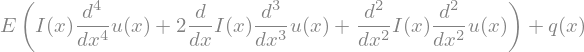

In [14]:
expr = (E * I *u.diff(x,2)).diff(x,2)+q
expr

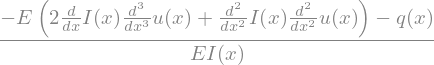

In [15]:
simplify(solve(expr, u.diff(x,4))[0])

$$ \frac{d^2}{dx^2}(EI(x)\frac{d^2u(x)}{dx^2}) = -q(x) $$


$$ \frac{d^4u(x)}{dx^4} = \frac{-1}{I\left(x \right)} \left(2 \frac{dI}{d x} {\left(x \right)} \frac{d^{3}u}{d x^{3}} {\left(x \right)} + \frac{d^{2}I}{d x^{2}} {\left(x \right)} \frac{d^{2}u}{d x^{2}} {\left(x \right)} + \frac {q\left(x \right)}{E}\right)$$

In [16]:
from chords.pseudospectral import _v_sum, piecewise, coll_points
from numpy import array

In [17]:
def bary_poly_num(t_arr, y_arr):
    """
    Generates a numeric function of t that corresponds to the polynomial
    that passes through the points (t, y) using the barycentric formula

    Parameters
    ----------
    t_arr : iterable of floats
        values of t
    y_arr : iterable of floats
        values of y

    Returns
    -------
    polynomial : Function F(t)
        polynomial numerical function

    """
    t = symbols("t")
    n = len(t_arr)
    v_arr = [_v_sum(t_arr, ii) for ii in range(n)]
    sup = 0
    for i in range(n):
        sup += v_arr[i] * y_arr[i] / (t - t_arr[i])
    inf = 0
    for i in range(n):
        inf += v_arr[i] / (t - t_arr[i])
    poly_fun = lambdify(
        [
            t,
        ],
        sup / inf,
    )
    
    def new_poly(t):
        t = array(t, dtype="float64")
        cond_list = [t == t_i for t_i in t_arr]
        func_list = list(y_arr)
        func_list.append(poly_fun)
        return piecewise(t, cond_list, func_list)

    return new_poly

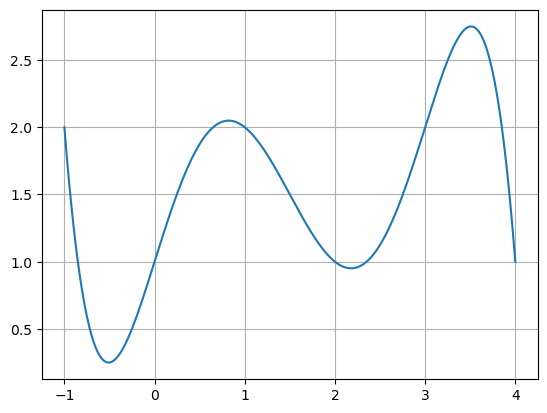

In [18]:
_a = bary_poly_num([-1,0,1,2,3,4], [2,1,2,1,2,1])
_t = np.linspace(-1,4,200)
plt.plot(_t, _a(_t))
plt.grid()

In [19]:
coll_points(5, 'LG')

In [20]:
from sympy import legendre_poly, jacobi_poly, evalf

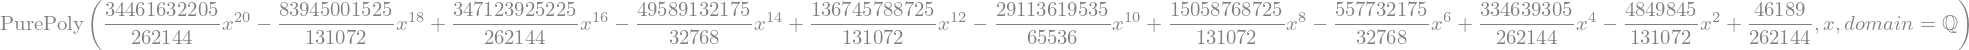

In [21]:
N = 20
_a =legendre_poly(N, polys=True)
_a

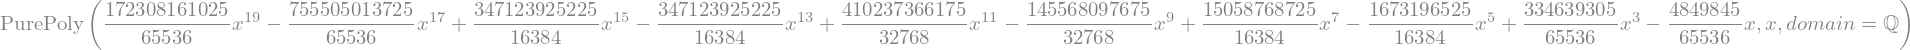

In [22]:
_a.diff()

In [23]:
from functools import lru_cache
from math import ceil

In [24]:
@lru_cache(maxsize=2000)
def LG_weight(N, i, precission = 20):
    Pn = legendre_poly(N, polys=True)
    Pn_d = Pn.diff()
    xi = coll_points(N, 'LG', precission)[i]
    wi = 2/((1-xi**2) * (Pn_d.eval(xi)**2))
    return wi

In [25]:
LG_weight(10,2)

In [26]:
def gauss_integral(f, N, t0, t1):
    scale = t1-t0
    points = (array(coll_points(N, 'LG'))+1)/2
    points = t0 + scale*points
    weights = [LG_weight(N, ii) for ii in range(N)]
    _a = [weights[ii]*f(points[ii]) for ii in range(N)]
    return scale*np.sum(_a)/2

In [27]:
def f_integral(f, N, t0, t1):
    scale = t1-t0
    points = (array(coll_points(N, 'LG'))+1)/2
    points = t0 + scale*points
    points = list(points)
    N_gauss = ceil((N+1)/2)
    y = [gauss_integral(f, N_gauss, t0, ii) for ii in points]
    points = [t0,] + points
    y = [0,] + y
    return bary_poly_num(points, y)

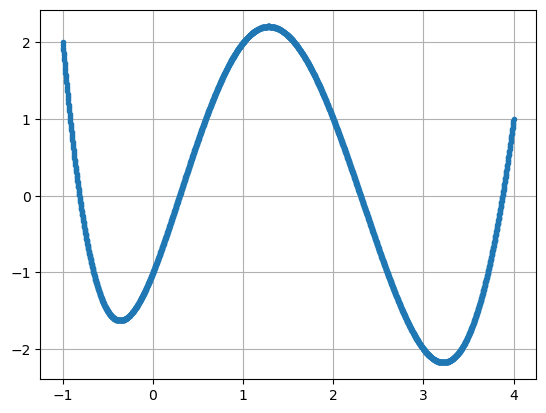

In [28]:
_a = bary_poly_num([-1,0,1,2,3,4], [2,-1,2,1,-2,1])
_t = np.linspace(-1,4,2000)
plt.plot(_t, _a(_t), '.')
plt.grid()

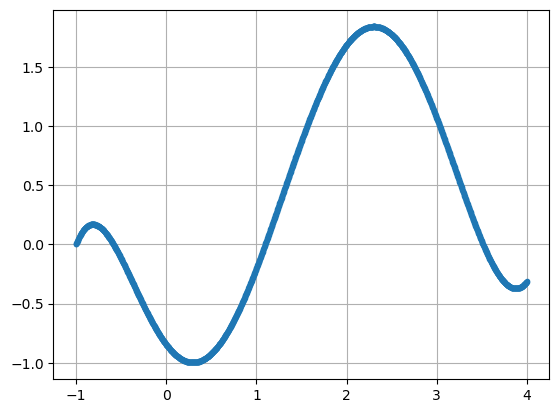

In [29]:
_b = f_integral(_a, 6, -1, 4)
plt.plot(_t, _b(_t), '.')
plt.grid()

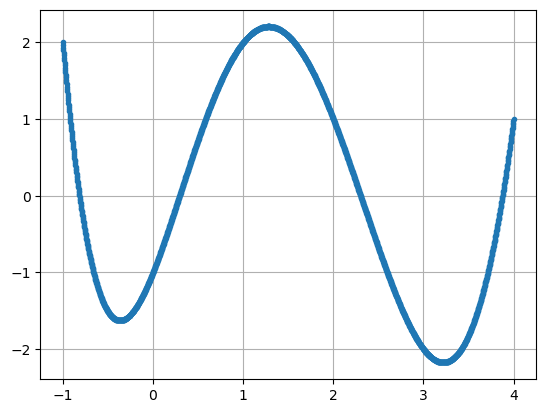

In [30]:
plt.plot(_t, np.gradient(_b(_t), _t, edge_order=2), '.')
plt.grid()

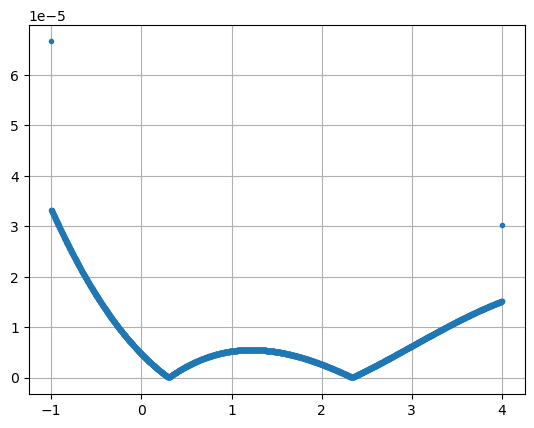

In [31]:
plt.plot(_t, np.abs(np.gradient(_b(_t), _t, edge_order=2)-_a(_t)), '.')
plt.grid()

In [32]:
def deletezeros(expr, tol = 1e-14):
    expr2 = expr
    for a in preorder_traversal(expr):
        if isinstance(a, Float):
            if abs(a) < tol:
                expr2 = expr2.subs(a, 0)
    return expr2

In [33]:
def bary_poly_sym(t_arr, y_arr):
    """
    Generates a symbolic function of t that corresponds to the polynomial
    that passes through the points (t, y) using the barycentric formula

    Parameters
    ----------
    t_arr : iterable of floats
        values of t
    y_arr : iterable of floats
        values of y

    Returns
    -------
    polynomial : Function F(t)
        polynomial numerical function

    """
    t = symbols("t")
    n = len(t_arr)
    v_arr = [_v_sum(t_arr, ii) for ii in range(n)]
    sup = 0
    for i in range(n):
        sup += v_arr[i] * y_arr[i] / (t - t_arr[i])
    inf = 0
    for i in range(n):
        inf += v_arr[i] / (t - t_arr[i])
    poly_fun = sup / inf

    return poly_fun

In [34]:
def poly_sym(t_arr, y_arr):
    """
    Generates a symbolic function of t that corresponds to the polynomial
    that passes through the points (t, y)

    Parameters
    ----------
    t_arr : iterable of floats
        values of t
    y_arr : iterable of floats
        values of y

    Returns
    -------
    polynomial : Function F(t)
        polynomial numerical function

    """
    t = symbols("t")
    n = len(t_arr)
    v_arr = [_v_sum(t_arr, ii) for ii in range(n)]
    sup = 0
    for i in range(n):
        sup += v_arr[i] * y_arr[i] / (t - t_arr[i])
    inf = 0
    for i in range(n):
        inf += v_arr[i] / (t - t_arr[i])
    poly_fun = sup / inf

    return deletezeros(simplify(poly_fun))

In [35]:
_a = bary_poly_sym([-1,0,1,2,3,4], [2,1,-2,1,-2,1])

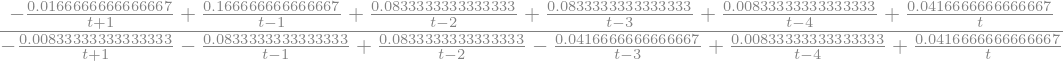

In [36]:
_a

In [37]:
from chords.symbolic import diff_to_symb_expr

In [38]:
x = q1**2 + cos(q2.diff())**3 + sin(q1**2) + acos(q1)
x

In [39]:
from chords.symbolic import print_funcs

In [40]:
print_funcs(x,3)

def F(x, ):
    q_0, q_1, q_2, v_0, v_1, v_2 = unpack(x)
    result = q_1**2 + np.sin(q_1**2) + np.cos(v_2)**3 + np.arccos(q_1)

    return result



'def F(x, ):\n    q_0, q_1, q_2, v_0, v_1, v_2 = unpack(x)\n    result = q_1**2 + np.sin(q_1**2) + np.cos(v_2)**3 + np.arccos(q_1)\n\n    return result\n'

In [41]:
x, a, b, c, d, t, h= symbols('x a b c d t h')
t0, t1, t2, t3, t4 = symbols('t_0 t_1 t_2 t_3 t_4')

In [42]:
sin(pi/2 + a-b)

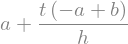

In [43]:
rect = a+ (b-a)/h*t
rect

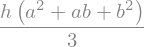

In [44]:
form = integrate(expand(rect**2), (t, 0, h))
form = simplify(form)
factor(form)

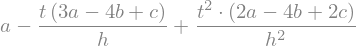

In [45]:
parab = a - t/h* (3*a-4*b+c) + t**2/h**2 * (2*a -4*b +2*c)
parab

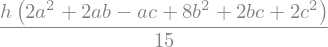

In [46]:
form = integrate(expand(parab**2), (t, 0, h))
form = simplify(form)
factor(form)

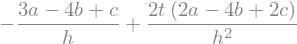

In [47]:
parab.diff(t)

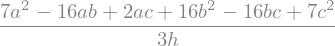

In [48]:
form_2 = integrate(expand(parab.diff(t)**2), (t, 0, h))
form_2 = simplify(form_2)
factor(form_2)

In [49]:
from sympy.printing.numpy import NumPyPrinter

def printer(x):
    np_printer = NumPyPrinter()
    return np_printer.doprint(x)

In [50]:
printer(form)

'(1/15)*h*(2*a**2 + 2*a*b - a*c + 8*b**2 + 2*b*c + 2*c**2)'

In [51]:
polin = a*x**3 + b*x**2 + c*x + d
polin

In [52]:
x_n = [polin.subs(x, ii) for ii in [t0, t1, t2, t3]]
x_n

In [53]:
pol_dif = polin.diff(x)
pol_dif

In [54]:
def x_roots(n):
    return roots_jacobi(n+1, 1, 0)[0]
def element(x, xm, xj):
    return (x-xm)/(xj-xm)

def L_pol(j,k):
    prod = 1
    #x_list = symbols(f'x_0:{k+1}')
    x_list = x_roots(k)
    for m in range(k+1):
        if m != j:
            prod *= element(x, x_list[m], x_list[j])
    return expand(prod) 

def L_pol_sym(j,k):
    prod = 1
    x_list = symbols(f'x_0:{k+1}')
    #x_list = x_roots(k)
    for m in range(k+1):
        if m != j:
            prod *= element(x, x_list[m], x_list[j])
    return expand(prod) 

def lagpol(n):
    sumat = 0
    q_list = symbols(f'f_0:{n+2}')
    for ii in range(n+1):
        sumat += L_pol(ii, n)*q_list[ii]
    return sumat

def lagpol_sym(n):
    sumat = 0
    q_list = symbols(f'f_0:{n+2}')
    for ii in range(n+1):
        sumat += L_pol_sym(ii, n)*q_list[ii]
    return sumat

def abcpol(n):
    abc = symbols(f'a b c d e f g h i j k l m n o p q r s t u v w a_0:{max(0,n-22)}')
    sumat = 0
    for ii in range(n+1):
        sumat += abc[ii]*x**ii
    return sumat

def lagpol_abc(n):
    sumat = 0
    x_list = x_roots(n)
    abc = abcpol(2*n-1)
    q_list = [abc.subs(x, x_list[ii]) for ii in range(n+1)]
    for ii in range(n+1):
        sumat += L_pol(ii, n)*q_list[ii]
    return sumat

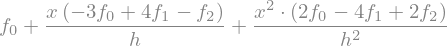

In [55]:
psi_accel_hs = lagpol_sym(2).subs([
    [symbols('x_0'), 0],
    [symbols('x_1'), h*Rational(1,2)],
    [symbols('x_2'), h]    
]).expand().collect(h).collect(x)
psi_accel_hs

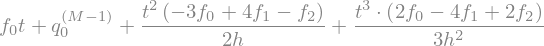

In [56]:
exp = integrate(psi_accel_hs, (x, 0, t))+symbols('q^{(M-1)}_0')
exp

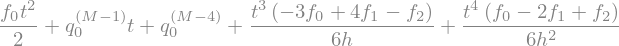

In [57]:
exp = integrate(exp, (t, 0, t))+symbols('q^{(M-4)}_0')
exp

In [58]:
from math import factorial

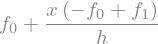

In [59]:
psi_accel_tz = lagpol_sym(1).subs([
    [symbols('x_0'), 0],
    [symbols('x_1'), h]    
]).expand().collect(h).collect(x)
psi_accel_tz

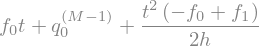

In [60]:
exp = integrate(psi_accel_tz, (x, 0, t))+symbols('q^{(M-1)}_0')
exp

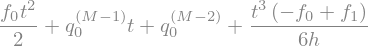

In [61]:
exp = integrate(exp, (t, 0, t))+symbols('q^{(M-2)}_0')
exp

In [62]:
import importlib

import chords
importlib.reload(chords.bu_pseudospectral)
importlib.reload(chords.util)

In [63]:
from chords.bu_pseudospectral import (
    Integration_Matrix, tau_to_t_points, BU_coll_points, BU_construction_points, _matrix_D_bary,
)
from chords.pseudospectral import LG, bary_poly
from chords.util import poly_integral

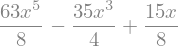

In [64]:
legendre_poly(5)

In [65]:
def ran(m, d):
    return m + d * np.random.randn()

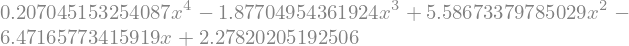

In [66]:
Pol_deg = 4
t0 = 0
tf = 4
scheme = 'LG'
N_col = 3

h = tf-t0

q_sym = expand(legendre_poly(Pol_deg, x = x).subs(x, -1 + ran(0, 0.05)+2*ran(1,0.05)*(x-t0)/h))
for ii in range(Pol_deg + 1):
    q_sym += ran(0, (4**-ii))*x**ii
q_sym

In [67]:
q_f = lambdify(x, q_sym)

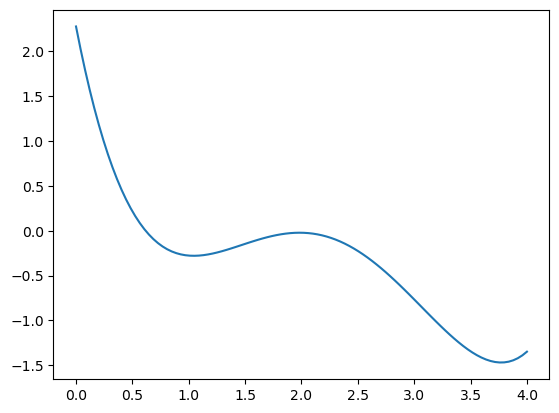

In [68]:
t0 = 0
tf = 4
t_arr = np.linspace(t0, tf,100)
plt.plot(t_arr, q_f(t_arr))

In [69]:
q_d_sym = q_sym.diff(x)
q_d_f = lambdify(x, q_d_sym)
q_dd_sym = q_d_sym.diff(x)
q_dd_f = lambdify(x, q_dd_sym)
q_ddd_sym = q_dd_sym.diff(x)
q_ddd_f = lambdify(x, q_ddd_sym)
q_dddd_sym = q_ddd_sym.diff(x)
q_dddd_f = lambda t : np.ones(len(t), dtype=float)* float(q_dddd_sym)

In [70]:
q_0 = q_f(t0)
q_d_0 = q_d_f(t0)
q_0, q_d_0

In [71]:
coll_points = BU_coll_points(N_col, scheme, order = 2)
coll_points_t = tau_to_t_points(coll_points, t0, tf)
coll_points_t

In [72]:
y_coll_points = q_dd_f(np.array(coll_points_t))

q_dd_lag = bary_poly(coll_points_t, y_coll_points)

In [73]:
q_dd_lag(2)

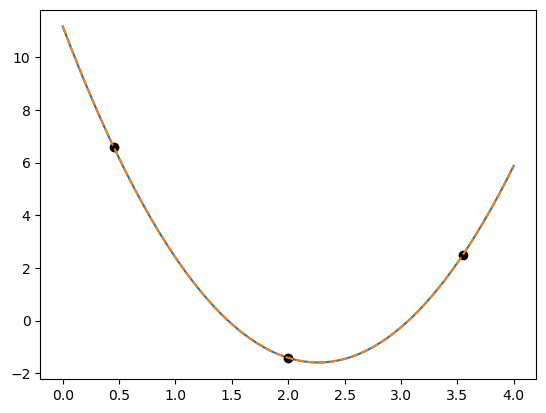

In [74]:
t_arr = np.linspace(t0, tf,100)
plt.plot(t_arr, q_dd_f(t_arr))
plt.plot(np.array(coll_points_t), y_coll_points, 'ok')
plt.plot(t_arr, q_dd_lag(t_arr), '--')

In [75]:
q_const = np.array([q_0, q_d_0]+list(y_coll_points), dtype = float).T
q_const

array([ 2.27820205, -6.47165773,  6.60127407, -1.41295957,  2.49860761])

In [76]:
IMv = Integration_Matrix(
    N_coll = N_col,
    scheme = scheme,
    deriv_order = 1,
    h = tf-t0,
    scheme_order=2,
    precission=20,)
IMv

array([[ 0.        ,  1.        ,  0.55575669, -0.14418717,  0.03923714],
       [ 0.        ,  1.        ,  1.20146702,  0.88836483, -0.08983185],
       [ 0.        ,  1.        ,  1.07239803,  1.92091682,  0.55587848],
       [ 0.        ,  1.        ,  1.11163517,  1.77672965,  1.11163517]])

In [77]:
t_points = [t0] + tau_to_t_points(BU_construction_points(N_col, scheme, order=2), t0, tf)
q_d_lag = poly_integral(q_dd_lag, N_col-1, t0, tf, q_d_0)

v_points = np.zeros_like(t_points)
v_points[0] = q_d_0
v_points[1:] = IMv@q_const
v_points, t_points

(array([-6.47165773415919, -2.5011866502174214, -0.02012277613173247,
        -0.7177200265006525, 1.133643641138044], dtype=object),
 [0, 0.4508066615170332, 2, 3.549193338482967, 4.0])

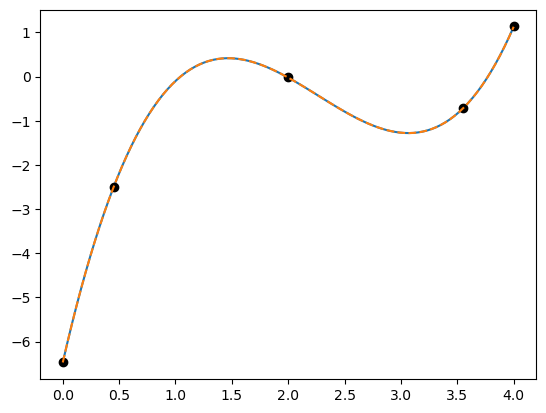

In [78]:
t_arr = np.linspace(t0, tf,100)
plt.plot(t_arr, q_d_f(t_arr))
plt.plot(t_points, v_points, 'ok')
plt.plot(t_arr, q_d_lag(t_arr), '--')

In [79]:
IMq = Integration_Matrix(
    N_coll = N_col,
    scheme = scheme,
    deriv_order = 1,
    h = tf-t0,
    scheme_order=2,
    precission=20,)
IMq

array([[ 0.        ,  1.        ,  0.55575669, -0.14418717,  0.03923714],
       [ 0.        ,  1.        ,  1.20146702,  0.88836483, -0.08983185],
       [ 0.        ,  1.        ,  1.07239803,  1.92091682,  0.55587848],
       [ 0.        ,  1.        ,  1.11163517,  1.77672965,  1.11163517]])

In [80]:
q_lag = poly_integral(q_d_lag, N_col, t0, tf, q_0)


q_points = np.zeros_like(t_points)
q_points[0] = q_0
q_points[1:] = IMq@q_const
q_points

array([2.27820205192506, -2.5011866502174214, -0.02012277613173247,
       -0.7177200265006525, 1.133643641138044], dtype=object)

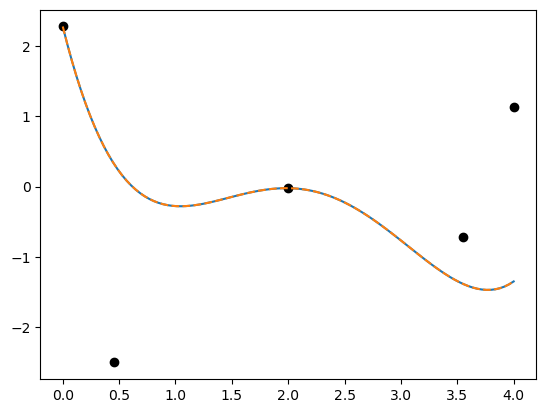

In [81]:
t_arr = np.linspace(t0, tf,100)
plt.plot(t_arr, q_f(t_arr))
plt.plot(t_points, q_points, 'ok')
plt.plot(t_arr, q_lag(t_arr), '--')

In [82]:
_matrix_D_bary(t_points)

array([[-3.25000000e+00,  3.69707639e+00, -6.66666667e-01,
         4.69590272e-01, -2.50000000e-01],
       [-1.33094750e+00,  9.68245837e-01,  5.16397779e-01,
        -3.22748612e-01,  1.69052498e-01],
       [ 3.75000000e-01, -8.06871530e-01,  1.11022302e-16,
         8.06871530e-01, -3.75000000e-01],
       [-1.69052498e-01,  3.22748612e-01, -5.16397779e-01,
        -9.68245837e-01,  1.33094750e+00],
       [ 2.50000000e-01, -4.69590272e-01,  6.66666667e-01,
        -3.69707639e+00,  3.25000000e+00]])

In [83]:
q_d_points  = q_d_f(np.array(t_points, dtype = float))

In [84]:
q_dd_mat_points = _matrix_D_bary(t_points) @ q_d_points
q_dd_mat_points

array([11.1734676 ,  6.60127407, -1.41295957,  2.49860761,  5.87694797])

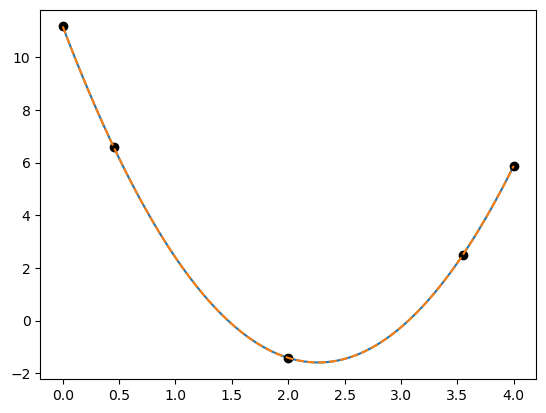

In [85]:
t_arr = np.linspace(t0, tf,100)
plt.plot(t_arr, q_dd_f(t_arr))
plt.plot(t_points, q_dd_mat_points, 'ok')
plt.plot(t_arr, q_dd_lag(t_arr), '--')

In [86]:
from cProfile import Profile
from pstats import SortKey, Stats

In [124]:
import chords
importlib.reload(chords)
importlib.reload(chords.bu_pseudospectral)
importlib.reload(chords.util)
importlib.reload(chords.pseudospectral)
from chords.bu_pseudospectral import (
    Integration_Matrix, tau_to_t_points, BU_coll_points, BU_construction_points, _matrix_D_bary,Lag_integ_2d
)
from chords.pseudospectral import bary_poly, bary_poly_2d
from chords.util import poly_integral_2d

In [88]:
Integration_Matrix(
    N_coll = N_col,
    scheme = scheme,
    deriv_order = 0,
    h = tf-t0,
    scheme_order=2,
    precission=20,)[:,:]

array([[ 1.        ,  0.45080666,  0.13338191, -0.04379596,  0.01202737],
       [ 1.        ,  2.        ,  1.69459229,  0.33254724, -0.02713953],
       [ 1.        ,  3.54919334,  3.455897  ,  2.70870178,  0.1337879 ],
       [ 1.        ,  4.        ,  3.94500217,  3.55345931,  0.50153853]])

In [89]:
Integration_Matrix(
    N_coll = N_col,
    scheme = scheme,
    deriv_order = 0,
    h = tf-t0,
    scheme_order=2,
    precission=20,)[:,:]

array([[ 1.        ,  0.45080666,  0.13338191, -0.04379596,  0.01202737],
       [ 1.        ,  2.        ,  1.69459229,  0.33254724, -0.02713953],
       [ 1.        ,  3.54919334,  3.455897  ,  2.70870178,  0.1337879 ],
       [ 1.        ,  4.        ,  3.94500217,  3.55345931,  0.50153853]])

In [90]:
Integration_Matrix(
    N_coll = N_col,
    scheme = scheme,
    deriv_order = 1,
    h = tf-t0,
    scheme_order=2,
    precission=20,)[:,:]

array([[ 0.        ,  1.        ,  0.55575669, -0.14418717,  0.03923714],
       [ 0.        ,  1.        ,  1.20146702,  0.88836483, -0.08983185],
       [ 0.        ,  1.        ,  1.07239803,  1.92091682,  0.55587848],
       [ 0.        ,  1.        ,  1.11163517,  1.77672965,  1.11163517]])

In [91]:
Integration_Matrix(
    N_coll = N_col,
    scheme = scheme,
    deriv_order = 1,
    h = tf-t0,
    scheme_order=2,
    precission=20,)[:,:]

array([[ 0.        ,  1.        ,  0.55575669, -0.14418717,  0.03923714],
       [ 0.        ,  1.        ,  1.20146702,  0.88836483, -0.08983185],
       [ 0.        ,  1.        ,  1.07239803,  1.92091682,  0.55587848],
       [ 0.        ,  1.        ,  1.11163517,  1.77672965,  1.11163517]])

In [92]:
((tf-t0)/2)**2*Lag_integ_2d(3, scheme, 2)(np.array(BU_construction_points(3, 'LG')))

array([[ 0.13338191, -0.04379596,  0.01202737],
       [ 1.69459229,  0.33254724, -0.02713953],
       [ 3.455897  ,  2.70870178,  0.1337879 ],
       [ 3.94500217,  3.55345931,  0.50153853]])

In [93]:
constr_points = (1 + np.array(BU_construction_points(3, 'LG'), dtype = float))*(tf-t0)/2

In [94]:
ii_arr = np.expand_dims(np.arange(1,2),0)
ii_arr

array([[1]])

In [95]:
from scipy.special import factorial

In [96]:
factorial(ii_arr)

array([[1.]])

In [97]:
np.expand_dims(constr_points,1)**ii_arr/factorial(ii_arr)

array([[0.45080666],
       [2.        ],
       [3.54919334],
       [4.        ]])

In [176]:
with Profile() as profile:
    Integration_Matrix(
        N_coll = 50,
        scheme = scheme,
        deriv_order = 1,
        h = tf-t0,
        scheme_order=2,
        precission=20,)
    (
         Stats(profile)
         .strip_dirs()
         .sort_stats(SortKey.CUMULATIVE)
         .print_stats()
     )

         80163845 function calls (79967347 primitive calls) in 32.211 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.017    0.017   32.211   32.211 bu_pseudospectral.py:386(Integration_Matrix)
     2550    0.006    0.000   31.125    0.012 bu_pseudospectral.py:326(_Lag_integ)
     2550    0.009    0.000   31.080    0.012 util.py:249(gauss_rep_integral)
     2550    0.226    0.000   30.288    0.012 util.py:237(gauss_integral)
   192654    0.239    0.000   22.529    0.000 decorators.py:224(_func)
   192650    0.134    0.000   20.597    0.000 decorators.py:99(binary_op_wrapper)
325619/323983    0.544    0.000   20.389    0.000 cache.py:67(wrapper)
    67500    0.059    0.000   19.426    0.000 expr.py:220(__rmul__)
68905/68880    0.543    0.000   18.767    0.000 operations.py:52(__new__)
    67551    0.954    0.000   17.628    0.000 mul.py:197(flatten)
   135284    0.257    0.000   13.760    0.000 assumptions.p

In [259]:
with Profile() as profile:
    Integration_Matrix(
        N_coll = 60,
        scheme = scheme,
        deriv_order = 1,
        h = tf-t0,
        scheme_order=2,
        precission=20,)
    (
         Stats(profile)
         .strip_dirs()
         .sort_stats(SortKey.CUMULATIVE)
         .print_stats()
     )

         15273888 function calls (15269567 primitive calls) in 9.016 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   11.603   11.603 bu_pseudospectral.py:404(Integration_Matrix)
      2/1    0.000    0.000    7.271    7.271 bu_pseudospectral.py:394(Lag_integ_2d)
        1    0.000    0.000    7.221    7.221 util.py:274(poly_integral_2d)
       60    0.001    0.000    7.220    0.120 util.py:256(poly_integral)
       60    0.004    0.000    7.164    0.119 util.py:264(<listcomp>)
     3600    0.047    0.000    7.160    0.002 util.py:237(gauss_integral)
     3600    0.030    0.000    7.084    0.002 util.py:244(<listcomp>)
   108000    0.061    0.000    7.054    0.000 util.py:296(<lambda>)
   108002    0.069    0.000    7.023    0.000 numpy.py:39(combined)
   108002    1.195    0.000    6.708    0.000 numpy.py:40(<listcomp>)
        1    0.000    0.000    4.302    4.302 bu_pseudospectral.py:93(BU_

In [203]:
with Profile() as profile:
    Lag_integ_2d(50, scheme, 2)(np.array(BU_construction_points(50, scheme)))
    (
         Stats(profile)
         .strip_dirs()
         .sort_stats(SortKey.CUMULATIVE)
         .print_stats()
     )

         13246573 function calls (13245181 primitive calls) in 6.653 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      3/1    0.000    0.000    7.944    7.944 bu_pseudospectral.py:392(Lag_integ_2d)
        2    0.001    0.000    7.619    3.809 util.py:274(poly_integral_2d)
      100    0.002    0.000    7.617    0.076 util.py:256(poly_integral)
      100    0.005    0.000    7.547    0.075 util.py:264(<listcomp>)
     5050    0.065    0.000    7.542    0.001 util.py:237(gauss_integral)
     5050    0.036    0.000    7.437    0.001 util.py:244(<listcomp>)
   128800    0.070    0.000    7.401    0.000 util.py:296(<lambda>)
   128803    0.080    0.000    7.375    0.000 numpy.py:39(combined)
   128803    1.196    0.000    7.037    0.000 numpy.py:40(<listcomp>)
  3315100    1.134    0.000    3.001    0.000 pseudospectral.py:522(new_poly)
  6569535    2.132    0.000    2.137    0.000 {built-in method numpy.array}
   267850 

In [98]:
from numpy.polynomial.legendre import leggauss

In [105]:
leggauss(10)[1]

array([0.06667134, 0.14945135, 0.21908636, 0.26926672, 0.29552422,
       0.29552422, 0.26926672, 0.21908636, 0.14945135, 0.06667134])

In [318]:
import chords
importlib.reload(chords)
importlib.reload(chords.bu_pseudospectral)
importlib.reload(chords.util)
importlib.reload(chords.pseudospectral)
from chords.bu_pseudospectral import (
    Integration_Matrix, tau_to_t_points, BU_coll_points, BU_construction_points, _matrix_D_bary,Lag_integ_2d
)
from chords.pseudospectral import bary_poly, bary_poly_2d
from chords.util import poly_integral_2d

In [319]:
from chords.util import get_weights, Lag_pol_2d, gauss_integral_2d, gauss_integral

In [288]:
LG(10)

In [289]:
leggauss(2)

(array([-0.57735027,  0.57735027]), array([1., 1.]))

In [290]:
p0 = bary_poly(LG(3), [1,0,0])

In [291]:
p0(leggauss(2)[0])

array([ 0.65045577, -0.09490022])

In [292]:
gauss_integral(p0, 2, -1, 1)

In [293]:
P3 = Lag_pol_2d(3, 'LG')

[-0.77459667  0.          0.77459667]


In [294]:
LG(3)

In [295]:
np.array(LG(3), dtype = 'float64')

array([-0.77459667,  0.        ,  0.77459667])

In [296]:
coll_points

In [297]:
np.sqrt(3/5)

In [298]:
P3(np.sqrt(3/5))

array([0., 0., 1.])

In [277]:
N = 3

In [255]:
leggauss(N)[1]

array([0.55555556, 0.88888889, 0.55555556])

In [256]:
weights(N,'LG')

array([0.55581759, 0.88836483, 0.55581759])

In [250]:
5/9, 8/9

In [196]:
N = 50
leggauss(N)[1] - weights(N,'LG')

array([ 2.09577920e-04, -1.45578449e-04, -2.55823739e-04,  2.98304185e-04,
        2.07360647e-04, -5.96356210e-04,  3.57415845e-04, -3.79042325e-04,
        4.59965439e-04, -7.85190116e-04,  5.06487106e-04, -5.07386088e-04,
        7.34110349e-04,  1.58547214e-04, -1.02666047e-03,  8.59529663e-04,
        1.83191004e-04, -4.31820552e-04,  3.68682687e-04, -3.79319599e-04,
        4.01652144e-04, -3.64405775e-04,  7.99976210e-05,  2.41673537e-05,
        2.25941473e-05,  2.25941473e-05,  2.41673537e-05,  7.99976210e-05,
       -3.64405775e-04,  4.01652144e-04, -3.79319599e-04,  3.68682687e-04,
       -4.31820552e-04,  1.83191004e-04,  8.59529663e-04, -1.02666047e-03,
        1.58547214e-04,  7.34110349e-04, -5.07386088e-04,  5.06487106e-04,
       -7.85190116e-04,  4.59965439e-04, -3.79042325e-04,  3.57415845e-04,
       -5.96356210e-04,  2.07360647e-04,  2.98304185e-04, -2.55823739e-04,
       -1.45578449e-04,  2.09577920e-04])

In [197]:
leggauss(N)[1]

array([0.00290862, 0.0067598 , 0.01059055, 0.01438082, 0.01811556,
       0.02178024, 0.02536067, 0.02884299, 0.03221373, 0.03545984,
       0.03856876, 0.04152846, 0.0443275 , 0.04695505, 0.04940094,
       0.0516557 , 0.05371062, 0.05555774, 0.05718993, 0.05860085,
       0.05978506, 0.06073797, 0.0614559 , 0.06193607, 0.06217662,
       0.06217662, 0.06193607, 0.0614559 , 0.06073797, 0.05978506,
       0.05860085, 0.05718993, 0.05555774, 0.05371062, 0.0516557 ,
       0.04940094, 0.04695505, 0.0443275 , 0.04152846, 0.03856876,
       0.03545984, 0.03221373, 0.02884299, 0.02536067, 0.02178024,
       0.01811556, 0.01438082, 0.01059055, 0.0067598 , 0.00290862])

In [198]:
gauss_integral_2d(Lag_pol_2d(N, 'LG'), N, -1,1)

array([0.00269904, 0.00690538, 0.01084637, 0.01408252, 0.0179082 ,
       0.0223766 , 0.02500326, 0.02922204, 0.03175376, 0.03624503,
       0.03806227, 0.04203585, 0.04359339, 0.0467965 , 0.0504276 ,
       0.05079617, 0.05352743, 0.05598957, 0.05682124, 0.05898017,
       0.05938341, 0.06110238, 0.0613759 , 0.0619119 , 0.06215402,
       0.06215402, 0.0619119 , 0.0613759 , 0.06110238, 0.05938341,
       0.05898017, 0.05682124, 0.05598957, 0.05352743, 0.05079617,
       0.0504276 , 0.0467965 , 0.04359339, 0.04203585, 0.03806227,
       0.03624503, 0.03175376, 0.02922204, 0.02500326, 0.0223766 ,
       0.0179082 , 0.01408252, 0.01084637, 0.00690538, 0.00269904])

In [220]:
LG(100)

In [221]:
weights(100,'LG')

array([0.00056198, 0.00299817, 0.00097032, 0.00468169, 0.00325225,
       0.00663655, 0.00660365, 0.00741348, 0.00813128, 0.00945569,
       0.01009522, 0.01135372, 0.01213383, 0.01318241, 0.01429941,
       0.01456431, 0.01544749, 0.01706104, 0.01657971, 0.01837545,
       0.01892446, 0.01970346, 0.02004031, 0.02234199, 0.02063509,
       0.02281495, 0.02360464, 0.02321304, 0.02423781, 0.02597413,
       0.02489874, 0.02603561, 0.02675398, 0.0276598 , 0.02720699,
       0.02840504, 0.02825107, 0.02938711, 0.02905786, 0.02971207,
       0.02967858, 0.03005875, 0.0303935 , 0.03066229, 0.0308641 ,
       0.03109531, 0.03091311, 0.03116419, 0.0312681 , 0.03124632,
       0.03124632, 0.0312681 , 0.03116419, 0.03091311, 0.03109531,
       0.0308641 , 0.03066229, 0.0303935 , 0.03005875, 0.02967858,
       0.02971207, 0.02905786, 0.02938711, 0.02825107, 0.02840504,
       0.02720699, 0.0276598 , 0.02675398, 0.02603561, 0.02489874,
       0.02597413, 0.02423781, 0.02321304, 0.02360464, 0.02281

In [222]:
np.sum(weights(100,'LG'))

In [223]:
zz = np.sqrt(1-leggauss(N)[0]**2)

In [225]:
yy = 2 * zz / np.sum(zz)

array([0.00206318, 0.00473054, 0.00740099, 0.01005509, 0.01268345,
       0.0152783 , 0.01783235, 0.02033856, 0.0227901 , 0.02518032,
       0.02750274, 0.02975108, 0.03191927, 0.03400145, 0.03599201,
       0.03788556, 0.03967701, 0.04136152, 0.04293454, 0.04439183,
       0.04572947, 0.04694385, 0.04803168, 0.04899004, 0.04981634,
       0.05050836, 0.05106423, 0.05148245, 0.05176189, 0.0519018 ,
       0.0519018 , 0.05176189, 0.05148245, 0.05106423, 0.05050836,
       0.04981634, 0.04899004, 0.04803168, 0.04694385, 0.04572947,
       0.04439183, 0.04293454, 0.04136152, 0.03967701, 0.03788556,
       0.03599201, 0.03400145, 0.03191927, 0.02975108, 0.02750274,
       0.02518032, 0.0227901 , 0.02033856, 0.01783235, 0.0152783 ,
       0.01268345, 0.01005509, 0.00740099, 0.00473054, 0.00206318])

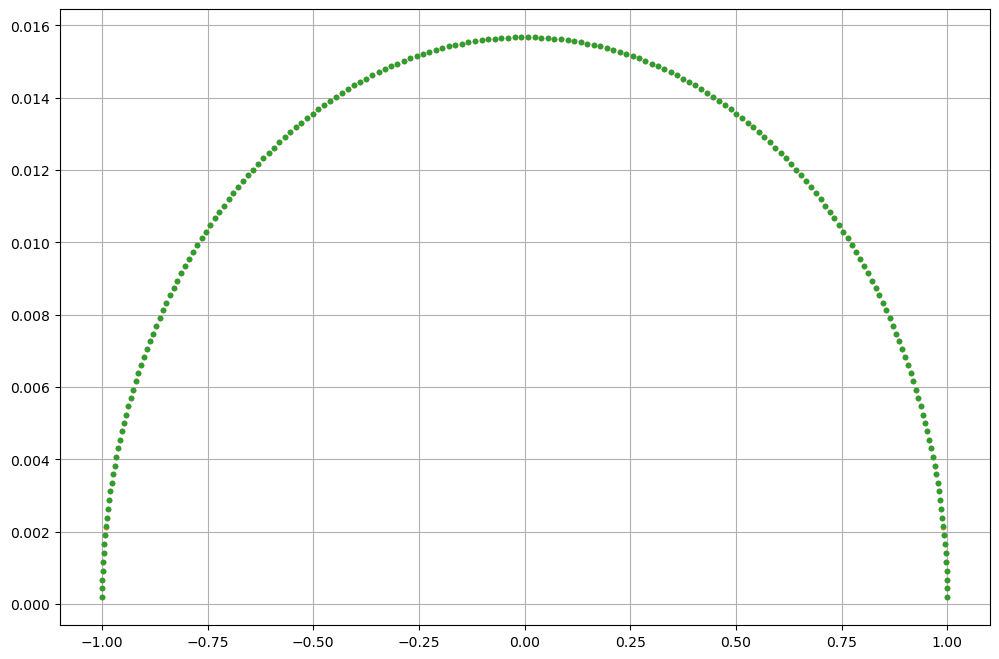

In [309]:
N = 200
plt.figure(figsize=[12,8])
zz = np.sqrt(1-leggauss(N)[0]**2)
yy = 2. * zz / np.sum(zz)
plt.plot(leggauss(N)[0],leggauss(N)[1], '.')
plt.plot(leggauss(N)[0],weights(N,'LG'), '.')
plt.plot(leggauss(N)[0],yy, '.')
plt.grid()

In [311]:
from chords.pseudospectral import LGL

In [316]:
%%timeit
LGL(210)

The slowest run took 19.32 times longer than the fastest. This could mean that an intermediate result is being cached.
568 ns ± 960 ns per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [246]:
leggauss(N)[1] - yy

array([-3.33562683e-06, -1.67717061e-06, -1.09347550e-06, -8.03097308e-07,
       -6.29612924e-07, -5.13863810e-07, -4.30722859e-07, -3.67761709e-07,
       -3.18144967e-07, -2.77807663e-07, -2.44182946e-07, -2.15571111e-07,
       -1.90802450e-07, -1.69045893e-07, -1.49694931e-07, -1.32296694e-07,
       -1.16506308e-07, -1.02056591e-07, -8.87374117e-08, -7.63812919e-08,
       -6.48531547e-08, -5.40428988e-08, -4.38599177e-08, -3.42290047e-08,
       -2.50872459e-08, -1.63816363e-08, -8.06723142e-09, -1.05694048e-10,
        7.53585465e-09,  1.48857507e-08,  2.19685281e-08,  2.88055172e-08,
        3.54153353e-08,  4.18142881e-08,  4.80167057e-08,  5.40352166e-08,
        5.98809830e-08,  6.55638949e-08,  7.10927367e-08,  7.64753245e-08,
        8.17186294e-08,  8.68288781e-08,  9.18116415e-08,  9.66719102e-08,
        1.01414162e-07,  1.06042419e-07,  1.10560295e-07,  1.14971042e-07,
        1.19277588e-07,  1.23482571e-07,  1.27588368e-07,  1.31597120e-07,
        1.35510760e-07,  

In [300]:
leggauss(N)[1] - weights(N,'LG')

array([-4.72964224e-15,  5.64750070e-15, -2.77100391e-15, -4.99817202e-17,
        3.09648140e-16, -3.06612374e-16, -5.38848480e-16,  9.51062146e-16,
       -6.03683770e-16,  1.92944619e-15, -7.12103987e-16,  4.24573571e-16,
       -1.92120625e-16,  6.28837260e-16, -4.32813507e-16, -1.48752538e-16,
        1.05818132e-16,  3.22658567e-16, -2.77555756e-16, -2.53269627e-16,
       -3.14852311e-16,  6.11490025e-16, -1.87350135e-16,  5.04804532e-16,
       -4.77048956e-16,  3.98986399e-16, -2.38524478e-16, -1.82145965e-17,
       -1.62196645e-16,  9.97465999e-17, -1.11022302e-16,  3.94649591e-16,
       -1.92554306e-16, -9.19403442e-17, -1.37043155e-16,  1.99493200e-16,
       -3.46944695e-17, -8.67361738e-18, -2.55004351e-16,  4.33680869e-17,
       -3.17454396e-16,  9.54097912e-17, -1.73472348e-17,  2.63677968e-16,
       -4.64905892e-16,  4.33680869e-17,  2.77555756e-17,  0.00000000e+00,
       -1.38777878e-17,  2.65412692e-16, -2.08166817e-17, -1.14491749e-16,
       -2.22044605e-16,  

In [200]:
_  = Lag_pol_2d(10, 'LG')

In [201]:
gauss_integral_2d(Lag_pol_2d(N, 'LG'), N, -1,1)

array([0.00221354, 0.0039933 , 0.00753781, 0.01018435, 0.01292241,
       0.01475132, 0.01835574, 0.02059593, 0.02220786, 0.02533289,
       0.02851129, 0.02848849, 0.03219135, 0.03401899, 0.03629348,
       0.03799003, 0.03985283, 0.04049843, 0.04347104, 0.04416928,
       0.04587848, 0.04668677, 0.04826462, 0.04907532, 0.04977269,
       0.05064002, 0.05097126, 0.05153225, 0.05169599, 0.05190222,
       0.05190222, 0.05169599, 0.05153225, 0.05097126, 0.05064002,
       0.04977269, 0.04907532, 0.04826462, 0.04668677, 0.04587848,
       0.04416928, 0.04347104, 0.04049843, 0.03985283, 0.03799003,
       0.03629348, 0.03401899, 0.03219135, 0.02848849, 0.02851129,
       0.02533289, 0.02220786, 0.02059593, 0.01835574, 0.01475132,
       0.01292241, 0.01018435, 0.00753781, 0.0039933 , 0.00221354])

In [161]:
_(np.linspace(-1,1,4))

array([[ 1.59688919, -1.02967811,  0.76454807, -0.58775971,  0.44944372,
        -0.33292835,  0.23222114, -0.14579754,  0.07439559, -0.021334  ],
       [-0.01506327,  0.05976041, -0.16196533,  0.76061019,  0.47514683,
        -0.18168794,  0.09943461, -0.05537632,  0.02652051, -0.00737969],
       [-0.00737969,  0.02652051, -0.05537632,  0.09943461, -0.18168794,
         0.47514683,  0.76061019, -0.16196533,  0.05976041, -0.01506327],
       [-0.021334  ,  0.07439559, -0.14579754,  0.23222114, -0.33292835,
         0.44944372, -0.58775971,  0.76454807, -1.02967811,  1.59688919]])

In [165]:
np.expand_dims(leggauss(10)[0], 1)

array([[-0.97390653],
       [-0.86506337],
       [-0.67940957],
       [-0.43339539],
       [-0.14887434],
       [ 0.14887434],
       [ 0.43339539],
       [ 0.67940957],
       [ 0.86506337],
       [ 0.97390653]])

In [151]:
np.sum(weights(N,'LG'))

In [127]:
from scipy.special import roots_legendre

In [128]:
roots_legendre(10)

(array([-0.97390653, -0.86506337, -0.67940957, -0.43339539, -0.14887434,
         0.14887434,  0.43339539,  0.67940957,  0.86506337,  0.97390653]),
 array([0.06667134, 0.14945135, 0.21908636, 0.26926672, 0.29552422,
        0.29552422, 0.26926672, 0.21908636, 0.14945135, 0.06667134]))

In [129]:
%%timeit
roots_legendre(10)

67.5 µs ± 891 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [368]:
from chords.util import gauss_integral, gauss_integral_2d, leggauss, combinefunctions
from chords.pseudospectral import bary_poly_2d

In [369]:
def poly_integral_2d(f, n_pol, t0, t1, y0=0):
    y_example = f(t0)
    if len(y_example.shape) >= 2:
        raise NotImplementedError(
            f"The output of f has shape {y_example.shape} but implemented "
            + "methods only allow for shape [n,]"
        )
    if len(y_example) == 1:
        return poly_integral(f, n_pol, t0, t1, y0)
    dim = y_example.shape[0]

    y0 = np.array(y0)
    if y0.shape != y_example.shape:
        if y0.shape == () or len(y0) == 1:
            y0 = y0 * np.ones(dim)
        else:
            raise ValueError(
                f"y0 has unexpected shape {y0.shape}, expected was {y_example.shape}"
            )

    pols = []
    for ii in range(dim):
        _part_pol = lambda t: f(t)[ii]
        pols.append(poly_integral(_part_pol, n_pol, t0, t1, y0[ii]))

    return combinefunctions(*pols)

In [378]:
def poly_integral_2d_b(f, n_pol, t0, t1, y0=0):
    y_example = f(t0)
    if len(y_example.shape) >= 2:
        raise NotImplementedError(
            f"The output of f has shape {y_example.shape} but implemented "
            + "methods only allow for shape (n,)"
        )
    if len(y_example) == 1:
        return poly_integral(f, n_pol, t0, t1, y0)
    dim = y_example.shape[0]

    y0 = np.array(y0)
    if y0.shape != y_example.shape:
        if y0.shape == () or len(y0) == 1:
            y0 = y0 * np.ones(dim)
        else:
            raise ValueError(
                f"y0 has unexpected shape {y0.shape}, expected was {y_example.shape}"
            )
    scale = t1 - t0
    nq = y_example.shape[0]

    points = (np.array(leggauss(n_pol + 1)[0], dtype = 'float64') + 1) / 2
    points = t0 + scale * points
    
    mat = np.zeros([n_pol+2, nq], dtype = 'float64')

    N_gauss = ceil((n_pol + 1) / 2)
    
    for ii in range(n_pol+1):
        mat[ii+1,:] = gauss_integral_2d(f, N_gauss, t0, points[ii])
    mat = np.expand_dims(y0, 0) + mat
    points = np.concatenate((np.expand_dims(t0,0), points))
    

    return bary_poly_2d(points, mat)

In [379]:
LL = Lag_pol_2d(5, 'LG')

In [380]:
poly_integral_2d(LL, 4, -1, 1)(leggauss(5)[0])

array([[ 0.11846344, -0.03914073,  0.0225088 , -0.01118759,  0.00317623],
       [ 0.25630201,  0.23931434, -0.04918423,  0.02063656, -0.00553799],
       [ 0.22755258,  0.5200093 ,  0.28444444, -0.04138063,  0.00937431],
       [ 0.24246487,  0.45799211,  0.61807312,  0.23931434, -0.01937513],
       [ 0.23375066,  0.48981626,  0.54638009,  0.5177694 ,  0.11846344]])

In [381]:
poly_integral_2d_b(LL, 4, -1, 1)(leggauss(5)[0])

array([[ 0.11846344, -0.03914073,  0.0225088 , -0.01118759,  0.00317623],
       [ 0.25630201,  0.23931434, -0.04918423,  0.02063656, -0.00553799],
       [ 0.22755258,  0.5200093 ,  0.28444444, -0.04138063,  0.00937431],
       [ 0.24246487,  0.45799211,  0.61807312,  0.23931434, -0.01937513],
       [ 0.23375066,  0.48981626,  0.54638009,  0.5177694 ,  0.11846344]])

In [392]:
N = 50

In [389]:
LL = Lag_pol_2d(N, 'LG')
poly_integral_2d(LL, N-1, -1, 1)(leggauss(N)[0])- poly_integral_2d_b(LL, N-1, -1, 1)(leggauss(N)[0])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [393]:
%%timeit
poly_integral_2d(LL, N-1, -1, 1)(leggauss(N)[0])

1.38 s ± 3.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [394]:
%%timeit
poly_integral_2d_b(LL, N-1, -1, 1)(leggauss(N)[0])

56.6 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


SX([u_0, u_1, u_2, u_3, u_4])

In [307]:
cas.sum1(weights(5, 'LG')*cas.SX.sym("u", 5))

SX(@1=0.236927, (((((@1*u_0)+(0.478629*u_1))+(0.568889*u_2))+(0.478629*u_3))+(@1*u_4)))

In [77]:
from chords.bu_pseudospectral import _matrix_D_bary

In [97]:
_D_mat = _matrix_D_bary(coll_points_t)
_D_mat

array([[-0.96824584,  1.29099445, -0.32274861],
       [-0.32274861, -0.        ,  0.32274861],
       [ 0.32274861, -1.29099445,  0.96824584]])

In [82]:
np.linalg.pinv(_D_mat)

array([[-6.45497224e-01, -5.16397779e-01, -3.87298335e-01],
       [ 2.58198890e-01,  1.21618839e-16, -2.58198890e-01],
       [ 3.87298335e-01,  5.16397779e-01,  6.45497224e-01]])

In [104]:
_D_mat @ y_coll_points

array([-11.525587872967633997, -1.3008162759359205008,
       8.9239553210957927719], dtype=object)

In [103]:
v_points[1:-1]

array([-2.404599847902053, 0.04685683416967677, -0.6236455460048005],
      dtype=object)

In [ ]:
def ffff(*args, b):
    print(f'args: {args}, b: {b}')

In [ ]:
ffff(1,2,3)

In [ ]:
from scipy.interpolate import CubicHermiteSpline as hermite

In [ ]:
hhh = hermite(t_points, q_d_points, q_dd_mat_points)

In [ ]:
t_arr = np.linspace(t0, tf,100)
plt.plot(t_arr, q_d_f(t_arr))
plt.plot(t_points, q_d_points, 'ok')
plt.plot(t_arr, hhh(t_arr), '--')

In [ ]:
hhh_d = hhh.derivative()

In [ ]:
t_arr = np.linspace(t0, tf,100)
plt.plot(t_arr, q_dd_f(t_arr))
plt.plot(t_points, q_dd_mat_points, 'ok')
plt.plot(t_arr, hhh_d(t_arr), '--')

In [ ]:
hhh_dd = hhh_d.derivative()
q_ddd_mat_points = _matrix_D_bary(t_points) @ q_dd_mat_points

In [ ]:
t_arr = np.linspace(t0, tf,100)
plt.plot(t_arr, q_ddd_f(t_arr))
plt.plot(t_points, q_ddd_mat_points, 'ok')
plt.plot(t_arr, hhh_dd(t_arr), '--')

In [ ]:
hhh_ddd = hhh_dd.derivative()
q_dddd_mat_points = _matrix_D_bary(t_points) @ q_ddd_mat_points

In [ ]:
q_dddd_f(t_arr)

In [ ]:
t_arr = np.linspace(t0, tf,100)
plt.plot(t_arr, q_dddd_f(t_arr))
plt.plot(t_points, q_dddd_mat_points, 'ok')
plt.plot(t_arr, hhh_ddd(t_arr), '--')

In [ ]:
indices = 'abcd'

In [ ]:
for ii,jj in enumerate(indices):
    print(f'ii: {ii}, jj: {jj}')

In [ ]:
import casadi as cas

In [ ]:
cas.vertcat()

In [ ]:
ab5 = abcpol(5)
ab5

In [ ]:
ab5_d = ab5.diff(x)
ab5_d

In [ ]:
ab5_dd = ab5_d.diff(x)
ab5_dd

In [ ]:
t0 = -1
t1 = 3

In [ ]:
gauss_integral(lambdify(x,ab5_d), 3, t0, t1)

In [ ]:
_F = lambdify(x,ab5)
_F(t1)-_F(t0)

In [ ]:
_ = gauss_rep_integral(lambdify(x,ab5_d), t0, t1, 4)
_[1]

---- 2o orden ----


In [ ]:
integrate(integrate(ab5_dd, (x, t0, x)),(x, t0, t1))

In [ ]:
_FFF, _res = gauss_rep_integral(lambdify(x,ab5_dd), t0, t1, 4, 2)  
_res

In [ ]:
_FFFX = _FFF(x)
_FFFX

In [ ]:
___ = lambdify(x, expand(integrate(expand(_FFFX),x)))
___(t1)- ___(t0)

In [ ]:
gauss_integral(_FFF, 3, t0, t1)

In [ ]:
_res + lambdify(x,ab5_d)(t0)*(t1-t0)

In [ ]:
_F(t1)-_F(t0)

In [ ]:
integrate(integrate(ab5_dd,x),x)

In [ ]:
_FF = lambdify(x, integrate(integrate(ab5_dd,x),x))
_FF(t1)-_FF(t0)

In [ ]:
q_0, q_1, q_c,v_0, v_1, v_c, a_0, a_1, a_c, g_0, g_1, g_c = symbols(
    'q_k q_{k+1} q_c v_k v_{k+1} v_c a_k a_{k+1} a_c g_k g_{k+1} g_c '
)
q_0, q_1, q_c,v_0, v_1, v_c, a_0, a_1, a_c, g_0, g_1, g_c

In [ ]:
from chords.piecewise import fac, is2d, vec_len, generate_hs_m_funcs, get_x_divisions
from copy import copy
from numpy import (
    zeros,
    append,
    concatenate,
    linspace,
    expand_dims,
    interp,
    array,
    sum,
    abs,
)



def get_x_divisions(x, order=2):
    dim = vec_len(x) // order
    x_list = []
    if is2d(x):
        for ii in range(order):
            index = (slice(None, None), slice(dim * ii, dim * (ii + 1)))
            print(index)
            x_list.append(x[index])
    else:
        for ii in range(order):
            index = slice(dim * ii, dim * (ii + 1))
            x_list.append(x[index])
    return x_list

def generate_hs_m_funcs(order):
    M = order  # in order to keep the paper naming
    q_coefs = zeros(order)
    for i in range(order):
        q_coefs[i] = 1 / fac(i)
    q_coefs_c = zeros(order - 1)
    for i in range(order - 1):
        q_coefs_c[i] = 1 / (2**i * fac(i))
    g_coefs = zeros(order + 1)
    g_coefs_c = zeros([order + 1, 5])
    for l in range(1, order + 1):
        g_coefs[l] = fac(l + 2)
        g_coefs_c[l, 0] = 2**l * fac(l) * (l + 2)
        g_coefs_c[l, 1] = 2 * l**2 + 4 * l - 3
        g_coefs_c[l, 2] = 2 ** (l + 1) * fac(l + 2)
        g_coefs_c[l, 3] = 2 * l**2 + 2 * l - 1
        g_coefs_c[l, 4] = -2 * l - 1

    def hs_m_half_x(x, x_n, a, a_n, dt):
        x_c = copy(x)
        x_list = get_x_divisions(x, order)
        x_n_list = get_x_divisions(x_n, order)
        x_c_list = get_x_divisions(x_c, order)
        v = x_list[-1]  # V represents here the highest q derivative contained in x
        v_n = x_n_list[-1]
        for l in range(1, M + 1):
            print( x_c_list[M - l])
            print(
                dt ** (l - 1) / g_coefs_c[l, 0] * (3 * v_n + g_coefs_c[l, 1] * v)
            )
            x_c_list[M - l][:,:] = (
                dt ** (l - 1) / g_coefs_c[l, 0] * (3 * v_n + g_coefs_c[l, 1] * v)
            )
            x_c_list[M - l][:,:] = x_c_list[M - l] + dt**l / g_coefs_c[l, 2] * (
                g_coefs_c[l, 3] * a + g_coefs_c[l, 4] * a_n
            )
            for i in range(l - 1):
                x_c_list[M - l][:,:] = (
                    x_c_list[M - l] + dt**i * q_coefs_c[i] * x_list[i + M - l]
                )
        return x_c, x_c_list

    def hs_m_accel_restr(x, x_n, a, a_n, dt, scheme_params):
        a_c = scheme_params.T
        res = copy(x)
        x_list = get_x_divisions(x, order)
        res_list = get_x_divisions(res, order)
        for l in range(1, M + 1):
            res_list[M - l][:,:] = (
                dt**l / g_coefs[l] * (l**2 * a + 4 * l * a_c + (2 - l) * a_n)
            )
            print(f'res:{res} res_list:{res_list}')
            for i in range(l):
                res_list[M - l][:,:] = (
                    res_list[M - l] + dt**i * q_coefs[i] * x_list[i + M - l]
                )
        return x_n - res

    return hs_m_half_x, hs_m_accel_restr

In [ ]:
def get_x_divisions(x, order=2, return_indices = False):
    dim = x.shape[-1] // order
    x_list = []
    if is2d(x):
        for ii in range(order):
            index = (slice(None, None), slice(dim * ii, dim * (ii + 1)))
            if return_indices:
                x_list.append(index)
            else:
                x_list.append(x[index])
    else:
        for ii in range(order):
            index = slice(dim * ii, dim * (ii + 1))
            if return_indices:
                x_list.append(index)
            else:
                x_list.append(x[index])
    return x_list



def _itemequal(arr_to, arr_from, shape, index=()):
    if len(shape) == 1:
        for ii in range(shape[0]):
            index_i = index + (ii,)
            arr_to[index_i] = arr_from[index_i]
    else:
        for ii in range(shape[0]):
            index_i = index + (ii,)
            shape_i = shape[1:]
            _itemequal(arr_to, arr_from, shape_i, index_i)
            
def itemequal(arr_to, arr_from):
    assert arr_from.shape == arr_to.shape
    shape = arr_from.shape
    _itemequal(arr_to, arr_from, shape, index=())
  
    
def reunite_matrix(arr, arr_list, order):
    indices = get_x_divisions(arr, order, return_indices=True)
    for ii in range(len(indices)):
        arr[indices[ii]] = arr_list[ii]


def generate_trapz_m_func(order):
    M = order  # in order to keep the paper naming
    q_coefs = zeros(order)
    for i in range(order):
        q_coefs[i] = 1 / fac(i)
    g_coefs = zeros(order + 1)
    for l in range(order + 1):
        g_coefs[l] = 1 / fac(l + 1)

    def trapz_m_accel_restr(x, x_n, a, a_n, dt, scheme_params):
        res = copy(x)
        x_list = get_x_divisions(x, order)
        res_list = get_x_divisions(res, order)
        for l in range(1, M + 1):
            _t = dt**l * g_coefs[l] * (l * a + a_n)
            itemequal(res_list[M - l], _t)
            for i in range(l):
                _t = (
                    res_list[M - l] + dt**i * q_coefs[i] * x_list[i + M - l]
                )
                itemequal(res_list[M - l], _t)
        reunite_matrix(res, res_list, order)        
        #print(f'applying value: a1={res_list}, a2 = {res}')
            
        return x_n - res

    return trapz_m_accel_restr

In [ ]:
_xc, _rest = generate_hs_m_funcs(3)

In [ ]:
_rest = generate_trapz_m_func(3)

In [ ]:
x_0 = Matrix([[q_0, v_0, a_0]])
x_1 = Matrix([[q_1, v_1, a_1]])
x_c = Matrix([[q_c, v_c, a_c]])

In [ ]:
_xc(x_0, x_1, Matrix([[g_0]]), Matrix([[g_1]]), h)

In [ ]:
print(x_0[:])

In [ ]:
_rest(x_0, x_1, Matrix([[g_0]]), Matrix([[g_1]]), h, Matrix([[g_c]]))

In [ ]:
x_0

In [ ]:
_z = x_0[(slice(None, None, None), slice(1, 2, None))]

In [ ]:
_z[:,:] = Matrix([[3]])

In [ ]:
x_0

In [ ]:
_z = get_x_divisions(x_0,3)

In [ ]:
_z

In [ ]:
_z[0][:,:] = Matrix([[3]])

In [ ]:
_z

In [ ]:
x_0

In [ ]:
is2d(x_0)

In [ ]:
import importlib

In [ ]:
importlib.reload(chords.pseudospectral)

In [ ]:
from chords.pseudospectral import LG, LGR, LGL, JG, JGR, JGR_inv, JGL

In [ ]:
LG(4)

In [ ]:
JG(4, order=1)

In [ ]:
LGR(4)

In [ ]:
JGR(4, order = 1)

In [ ]:
JGR_inv(4, order=1)

In [ ]:
LGL(4)

In [ ]:
JGL(4, order=1)